In [126]:
import sys, pathlib
import pandas as pd
import numpy as np
import joblib

# Ruta al proyecto
PROJECT_ROOT = pathlib.Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import importlib
from src import config as cfg
importlib.reload(cfg)  # Fuerza recarga de la nueva configuración
from src import evol_utils as eu
from sklearn.preprocessing import StandardScaler

#  Paths dinámicos 
if cfg.MODEL_TYPE == "lstm":
    MODEL_PATH = cfg.MODELS / cfg.LSTM_MODEL_NAME
    DATA_PATH  = cfg.DATA / "processed" / "lstm_data.pkl"
elif cfg.MODEL_TYPE == "lstm5d":
    MODEL_PATH = cfg.MODELS / cfg.LSTM5D_MODEL_NAME
    DATA_PATH  = cfg.DATA / "processed" / "lstm5d_data.pkl"
elif cfg.MODEL_TYPE == "gru5d":
    MODEL_PATH = cfg.MODELS / cfg.GRU5D_MODEL_NAME
    DATA_PATH = cfg.DATA / "processed" / "gru5d_data.pkl"
elif cfg.MODEL_TYPE == "ridge":
    MODEL_PATH = cfg.MODELS / "ridge.pkl"
    DATA_PATH  = cfg.DATA / "processed" / "lstm_data.pkl"
elif cfg.MODEL_TYPE == "xgb":
    MODEL_PATH = cfg.MODELS / cfg.XGB_MODEL_NAME
    DATA_PATH  = cfg.DATA / "processed" / "xgb_data.pkl"
elif cfg.MODEL_TYPE == "xgb_enhanced":
    MODEL_PATH = cfg.DATA / "processed" / "xgb_enhanced_model.pkl"  # ✅ FIX: Path correcto donde se guardó
    DATA_PATH  = cfg.DATA / "processed" / "xgb_enhanced_data.pkl"
elif cfg.MODEL_TYPE == "markowitz":
    MODEL_PATH = None  # Markowitz no necesita modelo entrenado
    DATA_PATH  = cfg.DATA / "processed" / "lstm_data.pkl"  # Solo necesita tickers
elif cfg.MODEL_TYPE == "cnn5d":
    MODEL_PATH = cfg.MODELS / "cnn5d.keras"
    DATA_PATH = cfg.DATA / "processed" / "cnn5d_data.pkl"
    scaler_cnn5d = joblib.load(cfg.MODELS / "scaler_X_cnn5d.pkl")


else:
    raise ValueError(f"Modelo '{cfg.MODEL_TYPE}' no soportado")

PRICES_PATH = cfg.DATA / "raw" / "prices.parquet"

print(f" Modelo activo: {cfg.MODEL_TYPE}")

 Modelo activo: gru5d


In [127]:
#  Datos 
df_prices = pd.read_parquet(PRICES_PATH).sort_index()
lstm_data = joblib.load(DATA_PATH)

# FIX: Extraer tickers según estructura de datos
if cfg.MODEL_TYPE in ["xgb_enhanced"]:
    # XGB Enhanced: DataFrame directo con columna 'ticker'
    tickers = lstm_data['ticker'].unique().tolist()
elif isinstance(lstm_data, dict) and "tickers" in lstm_data:
    # LSTM/otros: diccionario con clave 'tickers'
    tickers = lstm_data["tickers"]
else:
    # Fallback: usar tickers de precios existentes
    tickers = df_prices.columns.tolist()

df_prices = df_prices[tickers]
df_ret = np.log(df_prices / df_prices.shift(1)).dropna()

#opt if cfg.MODEL_TYPE == "lstm":
    # LSTM-1d: SOLO necesita retornos - NO calcular momentum innecesario
    df_feat = df_ret.shift(1).dropna()  # Solo retornos desplazados
    print("LSTM-1d optimizado: solo retornos (40 features)")
    
elif cfg.MODEL_TYPE == "lstm5d":
    # LSTM5d: necesita retornos + momentum + VIX
    vix = pd.read_parquet(cfg.DATA / "raw" / "vix.parquet").squeeze()
    vix = vix.ffill().reindex(df_ret.index).ffill()
    vix_t1 = vix.shift(1).rename('vix_t-1')
    
    # Momentum solo para LSTM5d
    ret5 = df_ret.rolling(5).sum()
    vol5 = df_ret.rolling(5).std()
    momentum = (ret5 / vol5).shift(1)
    
    df_feat = pd.concat([df_ret.shift(1), momentum, vix_t1], axis=1).dropna()
    print("LSTM5d: retornos + momentum + VIX (81 features)")
    
else:
    # Otros modelos: retornos + momentum (sin VIX)
    ret5 = df_ret.rolling(5).sum()
    vol5 = df_ret.rolling(5).std()
    momentum = (ret5 / vol5).shift(1)
    df_feat = pd.concat([df_ret.shift(1), momentum], axis=1).dropna()
    print(f"{cfg.MODEL_TYPE}: retornos + momentum (80 features)")

print(" df_feat shape:", df_feat.shape)

# === Cargar modelo y escalador ===
if cfg.MODEL_TYPE in ["lstm", "lstm5d","cnn5d"]:
    from tensorflow import keras
    # FIX: Deshabilitar safe_mode para cargar capas Lambda custom
    model = keras.models.load_model(MODEL_PATH, compile=False, safe_mode=False)
elif cfg.MODEL_TYPE == "gru5d":
    from tensorflow import keras
    model = keras.models.load_model(cfg.MODELS / cfg.GRU5D_MODEL_NAME, compile=False, safe_mode=False)
    DATA_PATH = cfg.DATA / "processed" / "gru5d_data.pkl"
elif cfg.MODEL_TYPE == "ridge":
    model = joblib.load(MODEL_PATH)
elif cfg.MODEL_TYPE == "xgb":
    model = joblib.load(MODEL_PATH)
elif cfg.MODEL_TYPE == "xgb_enhanced":
    model = joblib.load(MODEL_PATH)  # XGBoost enhanced usa el mismo mecanismo
elif cfg.MODEL_TYPE == "markowitz":
    model = None  # Markowitz no necesita modelo entrenado (usa medias históricas)
else:
    raise ValueError(f"Modelo '{cfg.MODEL_TYPE}' no soportado")

# Solo para lstm5d
if cfg.MODEL_TYPE == "lstm5d":
    scaler_lstm5d = joblib.load(cfg.MODELS / "scaler_X_lstm5d.pkl")


 gru5d: retornos + momentum (80 features)
df_feat shape: (1495, 80)


In [128]:
# 🔧 CORRECCIÓN CRÍTICA LSTM-5d: Agregar VIX para completar 81 features
if cfg.MODEL_TYPE == "lstm5d":
    # Cargar VIX y alinearlo con los precios
    vix = pd.read_parquet(cfg.DATA / "raw" / "vix.parquet").squeeze()
    vix = vix.ffill().reindex(df_ret.index).ffill()
    vix_t1 = vix.shift(1).rename('vix_t-1')
    
    # Recrear features completas: retornos + momentum + VIX
    df_feat = pd.concat([df_ret.shift(1), momentum, vix_t1], axis=1).dropna()
    print(" df_feat shape CORREGIDO (con VIX):", df_feat.shape)
    print("Features: retornos(40) + momentum(40) + VIX(1) = 81")
    print("Dimensiones compatibles con modelo LSTM-5d")
else:
    print("df_feat shape original:", df_feat.shape)


 df_feat shape original: (1495, 80)


In [129]:
from src import config as cfg
import joblib

ruta = cfg.MODELS / "scaler_y_lstm.pkl"
print(" Escalador existe:", ruta.exists())


Escalador existe: True


In [130]:
import joblib, numpy as np, pandas as pd, src.evol_utils as eu  # resto igual …
from src import predict_ridge
from src import predict_xgb_enhanced
import importlib
import warnings

# SILENCIAR WARNINGS ESPECÍFICOS de yfinance y pandas
warnings.filterwarnings('ignore', message='.*YF.download.*auto_adjust.*')
warnings.filterwarnings('ignore', message='.*Downcasting object dtype.*')

# SILENCIAR WARNINGS de scikit-learn sobre versiones y feature names
warnings.filterwarnings('ignore', message='.*Trying to unpickle estimator.*')
warnings.filterwarnings('ignore', message='.*X does not have valid feature names.*')

#  FORCE RELOAD módulo XGB Enhanced para aplicar cambios yfinance
importlib.reload(predict_xgb_enhanced)
from src.predict_xgb_enhanced import predict_xgb_enhanced

def _lazy_loader(var_name, pkl_path):
    if var_name not in globals():
        globals()[var_name] = joblib.load(pkl_path)
    return globals()[var_name]


def rebalancear_en_fecha(fecha, df_feat, model, w_prev=None):
    try:
        idx     = df_feat.index.get_loc(fecha)
        ventana = df_feat.iloc[idx - cfg.WINDOW: idx]

        #        if cfg.MODEL_TYPE == "lstm":
            # FIX DEFINITIVO: Usar el escalador del preprocessing que SÍ existe
            ventana_ret = df_ret.iloc[idx - cfg.WINDOW: idx]  # (60, 40) solo retornos
            
            # Cargar el escalador original del preprocessing que EXISTE
            data_scaler = _lazy_loader("ret_scaler", cfg.DATA / "processed" / "ret_scaler.pkl")
            
            # ESCALADO CORRECTO
            # Los datos ya vienen pre-escalados en el entrenamiento, pero necesitamos escalar raw data
            X_scaled = data_scaler.transform(ventana_ret.values)  # (60, 40) escalado
            X_input = X_scaled.reshape(1, cfg.WINDOW, -1)  # (1, 60, 40)
            
            # Predicción (modelo entrenado con datos pre-escalados, devuelve escalado)
            r_hat_scaled = model.predict(X_input, verbose=0)[0]
            
            # CONVERSIÓN A ESCALA ORIGINAL            r_hat = data_scaler.inverse_transform([r_hat_scaled])[0]
            
            # LOGGING DEBUG para verificar variabilidad
            if fecha == fechas[cfg.WINDOW]:  # Primera fecha
                print(f"🔍 DEBUG LSTM-1d - ventana range: [{ventana_ret.min().min():.6f}, {ventana_ret.max().max():.6f}]")
                print(f"🔍 DEBUG LSTM-1d - r_hat range: [{r_hat.min():.6f}, {r_hat.max():.6f}]")
            
            r_hat = np.clip(r_hat, -0.12, 0.12)

        elif cfg.MODEL_TYPE == "lstm5d":
            # CONSTRUIR FEATURES LSTM5D CON VIX 
            ventana_ret = df_ret.iloc[idx - cfg.WINDOW: idx]
            ret5        = df_ret.rolling(5).sum()
            vol5        = df_ret.rolling(5).std()
            momentum    = (ret5 / (vol5 + 1e-6)).shift(1)
            ventana_mom = momentum.loc[ventana_ret.index]
            
            # Cargar VIX y alinearlo  
            vix = pd.read_parquet(cfg.DATA / "raw" / "vix.parquet").squeeze()
            vix_t1 = vix.shift(1).reindex(ventana_ret.index).ffill()            
            # Combinar: [retornos(40) + momentum(40) + vix(1)] = 81 features
            ventana_vix = vix_t1.values.reshape(-1, 1)  # (60, 1)
            ventana_combined = np.concatenate([
                ventana_ret.values,      # (60, 40) retornos
                ventana_mom.values,      # (60, 40) momentum  
                ventana_vix              # (60, 1)  VIX
            ], axis=1)  # (60, 81) 
            
            scaler_X = _lazy_loader("scaler_X_lstm5d", cfg.MODELS / "scaler_X_lstm5d.pkl")
            X_scaled = scaler_X.transform(ventana_combined)    # (60, 81)
            X_input  = X_scaled.reshape(1, cfg.WINDOW, -1)     # (1, 60, 81) 
            r_hat    = model.predict(X_input, verbose=0)[0]
            scaler_y = _lazy_loader("scaler_y_lstm5d", cfg.MODELS / "scaler_y_lstm5d.pkl")
            r_hat    = scaler_y.inverse_transform([r_hat])[0]



        elif cfg.MODEL_TYPE == "cnn5d":
            scaler_X = _lazy_loader("scaler_X_cnn5d", cfg.MODELS / "scaler_X_cnn5d.pkl")
            #  CORRECCIÓN CNN5D
            n_assets = len(tickers)        # 40 assets
            n_chan   = 2                   # [ret, momentum]
            
            # Reshape ventana para CNN: (W, 2*n_assets) asta (W, n_assets, 2)
            ventana_ret = ventana.iloc[:, :n_assets].values      # (W, 40)
            ventana_mom = ventana.iloc[:, n_assets:].values      # (W, 40)
            ventana_4d = np.stack([ventana_ret, ventana_mom], axis=-1)  # (W, 40, 2)
            
            # Escalar            ventana_flat = ventana_4d.reshape(cfg.WINDOW, -1)   # (60, 80)
            X_scaled = scaler_X.transform(ventana_flat)         # (60, 80)
            X_4d = X_scaled.reshape(cfg.WINDOW, n_assets, n_chan)  # (60, 40, 2)
            X_input = X_4d.reshape(1, cfg.WINDOW, n_assets, n_chan)  # (1, 60, 40, 2)
            
            r_hat = model.predict(X_input, verbose=0)[0]
            scaler_y = _lazy_loader("scaler_y_cnn5d", cfg.MODELS / "scaler_y_cnn5d.pkl")
            r_hat = scaler_y.inverse_transform([r_hat])[0]   # vuelve a puntos %
            r_hat_10d = np.power(1 + r_hat, 10/5) - 1  # = (1 + r_hat_5d)^2 - 1
            r_hat = r_hat_10d                             # de 5-d → 1-d          # safety-clip ±12 %

        elif cfg.MODEL_TYPE == "gru5d":
            ventana_ret = df_ret.iloc[idx - cfg.WINDOW: idx]
            ret5        = df_ret.rolling(5).sum()
            vol5        = df_ret.rolling(5).std()
            momentum    = (ret5 / (vol5 + 1e-6)).shift(1)
            ventana_mom = momentum.loc[ventana_ret.index]
            ventana     = pd.concat([ventana_ret, ventana_mom], axis=1)

            scaler_X = _lazy_loader("scaler_X_gru5d", cfg.MODELS / "scaler_X_gru5d.pkl")
            X_scaled = scaler_X.transform(ventana.values)      # ← .values
            X_input  = X_scaled.reshape(1, cfg.WINDOW, -1)
            r_hat    = model.predict(X_input, verbose=0)[0]
            scaler_y = _lazy_loader("scaler_y_gru5d", cfg.MODELS / "scaler_y_gru5d.pkl")
            r_hat    = scaler_y.inverse_transform([r_hat])[0]
            # n            r_hat_10d = np.power(1 + r_hat, 10/5) - 1  # = (1 + r_hat_5d)^2 - 1
            r_hat = r_hat_10d

        elif cfg.MODEL_TYPE == "xgb":
            X_input = ventana.values                          # XGB sin escalar
            r_hat   = np.array([model[i].predict(X_input[-1].reshape(1, -1))[0]
                                for i in range(X_input.shape[1])])
        elif cfg.MODEL_TYPE == "ridge":
            r_hat_ser = predict_ridge.predict_ridge(df_prices, fecha, tickers)
            r_hat    = r_hat_ser.reindex(tickers).infer_objects(copy=False).fillna(0).values  #  FIX FutureWarning
        elif cfg.MODEL_TYPE == "xgb_enhanced":
            r_hat_ser = predict_xgb_enhanced(df_prices, fecha, tickers)
            r_hat    = r_hat_ser.reindex(tickers).infer_objects(copy=False).fillna(0).values  # FIX FutureWarning
            r_hat    = np.clip(r_hat, -0.12, 0.12)  # Safety clip para features avanzadas
        elif cfg.MODEL_TYPE == "markowitz":
            # Markowitz clásico: usa medias históricas de 60 días
            ventana_ret = df_ret.iloc[idx - cfg.WINDOW: idx]
            r_hat = ventana_ret.mean().values  # Media histórica como predicción
            r_hat = np.clip(r_hat, -0.05, 0.05)  # Clip conservador para medias
        else:
            raise ValueError("Tipo de modelo no reconocido")

        # ── 2. OPTIMIZACIÓN (sin cambios) ──────────────────────────────────
        fecha_ret   = df_feat.index[idx]
        ventana_ret = df_ret.loc[:fecha_ret - pd.Timedelta(days=1)].tail(cfg.WINDOW)
        Sigma       = ventana_ret.cov().values

        if r_hat.shape[0] != Sigma.shape[0]:
            print(f" Dim mismatch {fecha.date()}")
            return None

        res     = eu.resolver_optimizacion(r_hat, Sigma, w_prev=w_prev)
        w_star  = eu.elegir_w_star(res, r_hat, Sigma, w_prev=w_prev)

        turnover  = np.sum(np.abs(w_star - w_prev)) if w_prev is not None else 1.0
        
        #  CORREGIR DATA LEAKAGE: NO usar retornos futuros para ret_bruto
        # En backtest real, solo conocemos retornos hasta fecha actual
        # ret_bruto debe calcularse período por período en el loop principal
        # Por ahora, usamos ret_bruto = 0 (se calculará en el loop)
        ret_bruto_sum = 0.0  # Se calculará externamente con datos reales
        ret_neto  = ret_bruto_sum - turnover * cfg.COST_TRADE

        return {
            "fecha"    : fecha,
            "r_hat"    : r_hat,
            "ret_bruto": ret_bruto_sum,  #  Corregido: sin data leakage
            "ret_neto" : ret_neto,
            "turnover" : turnover,
            "w_star"   : w_star,
        }

    except Exception as e:
        print(f"ERROR {fecha.date()}: {e}")
        return None


In [132]:
fechas = df_feat.loc[cfg.START_BACKTEST:].index
resultados = []
w_prev = None                       # sin cartera previa en t₀

for i in range(cfg.WINDOW, len(fechas) - cfg.REBAL_FREQ, cfg.REBAL_FREQ):
    fecha = fechas[i]
    out = rebalancear_en_fecha(fecha, df_feat, model, w_prev=w_prev)

    if out is not None:
        #  CALCULAR RETORNOS SIN DATA LEAKAGE - período por período
        fecha_inicio = fecha
        fecha_fin_idx = min(i + cfg.REBAL_FREQ, len(fechas) - 1)
        fecha_fin = fechas[fecha_fin_idx]
        
        # Obtener retornos SOLO del período [fecha, fecha+REBAL_FREQ]
        ret_periodo = df_ret.loc[fecha_inicio:fecha_fin]
        if len(ret_periodo) > 0:
            # Retorno bruto como suma de retornos diarios ponderados
            ret_bruto_real = (ret_periodo.values @ out["w_star"]).sum()
            ret_neto_real = ret_bruto_real - out["turnover"] * cfg.COST_TRADE
            
            # Actualizar los valores reales (sin data leakage)
            out["ret_bruto"] = ret_bruto_real
            out["ret_neto"] = ret_neto_real
        
        resultados.append(out)

        turno_log = 0.0 if w_prev is None else np.sum(np.abs(out["w_star"] - w_prev))

        print(f" {fecha.date()} | Ret bruto {out['ret_bruto']:.4%} | "
              f"neto {out['ret_neto']:.4%} | turnover {turno_log:.2%}")

        w_prev = out["w_star"]      # cartera para el próximo ciclo
    else:
        print(f" {fecha.date()} | Resultado nulo")


✅ 2019-04-24 | Ret bruto -1.8035% | neto -2.0035% | turnover 0.00%
✅ 2019-05-10 | Ret bruto 1.2543% | neto 1.1874% | turnover 33.46%
✅ 2019-05-30 | Ret bruto 4.5522% | neto 4.4530% | turnover 49.58%
✅ 2019-06-18 | Ret bruto 3.5816% | neto 3.4935% | turnover 44.04%
✅ 2019-07-09 | Ret bruto -0.8689% | neto -0.9453% | turnover 38.22%
✅ 2019-07-25 | Ret bruto 1.6364% | neto 1.5636% | turnover 36.43%
✅ 2019-08-13 | Ret bruto -1.1076% | neto -1.1880% | turnover 40.17%
✅ 2019-08-29 | Ret bruto 4.3924% | neto 4.2977% | turnover 47.36%
✅ 2019-09-18 | Ret bruto -2.5226% | neto -2.6049% | turnover 41.13%
✅ 2019-10-04 | Ret bruto 0.8448% | neto 0.7585% | turnover 43.13%
✅ 2019-10-23 | Ret bruto 2.6710% | neto 2.5871% | turnover 41.93%
✅ 2019-11-08 | Ret bruto 1.2298% | neto 1.1468% | turnover 41.50%
✅ 2019-11-27 | Ret bruto 2.2077% | neto 2.1202% | turnover 43.74%
✅ 2019-12-18 | Ret bruto 1.7729% | neto 1.6867% | turnover 43.08%
✅ 2020-01-10 | Ret bruto 4.1474% | neto 4.0701% | turnover 38.65%
✅ 2

In [133]:
import pandas as pd
import joblib

res_df = pd.DataFrame(resultados).set_index("fecha")
joblib.dump(res_df, cfg.RESULT / f"backtest_{cfg.MODEL_TYPE}.pkl")
print("✅ Backtest guardado:", cfg.RESULT / f"backtest_{cfg.MODEL_TYPE}.pkl")
print(pd.DataFrame(resultados).columns)


 Backtest guardado: C:\Users\1M72763\Desktop\TFM\results\backtest_gru5d.pkl
Index(['fecha', 'r_hat', 'ret_bruto', 'ret_neto', 'turnover', 'w_star'], dtype='object')


In [134]:

import warnings
warnings.filterwarnings('ignore')

def load_benchmark_data(start_date, end_date):
    """Carga datos de benchmarks (SPY, BIL) para comparación"""
    import yfinance as yf
    import numpy as np
    
    # MÉTODO ROBUSTO BASADO EN EL NOTEBOOK 08
    # Descargar SPY primero (método probado)
    spy_data = yf.download("SPY", start=start_date, end=end_date, progress=False)
    
    # Convertir a DataFrame si es Series y obtener precios
    if isinstance(spy_data, pd.Series):
        spy_prices = spy_data.ffill()
    elif isinstance(spy_data, pd.DataFrame):
        # Buscar columna de precio de forma robusta
        price_cols = [col for col in spy_data.columns if 'Close' in str(col)]
        if price_cols:
            spy_prices = spy_data[price_cols[0]].ffill()
        elif len(spy_data.columns) == 1:
            spy_prices = spy_data.iloc[:, 0].ffill()  # Primera columna
        else:
            spy_prices = spy_data.iloc[:, -1].ffill()  # Última columna (usualmente Adj Close)
    else:
        raise ValueError("Formato de datos SPY no reconocido")
    
    # Calcular retornos del SPY (consistente con el resto del sistema)
    spy_ret = np.log(spy_prices / spy_prices.shift(1)).dropna()
    
    # Crear BIL sintético (proxy de cash ~2.5% anual) - log returns
    bil_ret = pd.Series([0.00010] * len(spy_ret), index=spy_ret.index)  # ~2.5% anual
    
    # Combinar en DataFrame
    bench_ret = pd.DataFrame({
        'SPY': spy_ret,
        'BIL': bil_ret
    })
    
    return bench_ret

def calculate_comprehensive_metrics(returns_series, name="Strategy", rebal_freq=1):
    """
    Calcula métricas de performance, CORREGIDO para frecuencia de rebalanceo.
    - rebal_freq: Frecuencia de rebalanceo en días (ej. 1 para diario, 10 para cada 10 días).
    """
    import numpy as np
    from scipy import stats
    
    periods_per_year = 252 / rebal_freq
    
    if len(returns_series) == 0:
        return { 'Estrategia': name, 'Retorno Total': '0.00%', 'Retorno Anual': '0.00%' }

    # Métricas básicas (usando log returns)
    total_log_return = returns_series.sum()
    total_return = np.exp(total_log_return) - 1
    
    n_obs = len(returns_series)
    annual_log_return = total_log_return / n_obs * periods_per_year
    annual_return = np.exp(annual_log_return) - 1
    
    annual_vol = returns_series.std() * np.sqrt(periods_per_year)
    sharpe = annual_return / annual_vol if annual_vol > 0 else 0
    
    # Drawdown (calculado sobre retornos aritméticos)
    cumulative = np.exp(returns_series.cumsum())
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_dd = drawdown.min()
    
    # Métricas avanzadas
    downside_vol = returns_series[returns_series < 0].std() * np.sqrt(periods_per_year)
    sortino = annual_return / downside_vol if downside_vol > 0 else 0
    
    var_95 = np.percentile(returns_series.dropna(), 5)
    cvar_95 = returns_series[returns_series <= var_95].mean()
    
    skewness = stats.skew(returns_series.dropna())
    kurtosis = stats.kurtosis(returns_series.dropna())
    win_rate = (returns_series > 0).mean()
    calmar = annual_return / abs(max_dd) if max_dd != 0 else 0
    
    return {
        'Estrategia': name, 'Retorno Total': f"{total_return:.2%}", 'Retorno Anual': f"{annual_return:.2%}",
        'Volatilidad Anual': f"{annual_vol:.2%}", 'Ratio Sharpe': f"{sharpe:.3f}", 'Ratio Sortino': f"{sortino:.3f}",
        'Drawdown Máximo': f"{max_dd:.2%}", 'VaR (95%)': f"{var_95:.2%}", 'CVaR (95%)': f"{cvar_95:.2%}",
        'Asimetría': f"{skewness:.3f}", 'Curtosis': f"{kurtosis:.3f}", 'Tasa Acierto': f"{win_rate:.2%}",
        'Ratio Calmar': f"{calmar:.3f}"
    }

def plot_equity_curves_comparison(strategy_returns, benchmark_returns, model_name):
    """Genera gráficos de comparación de curvas de equity"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Calculate cumulative returns (CORREGIDO para log returns)
    strategy_cum = np.exp(strategy_returns.cumsum())
    spy_cum = np.exp(benchmark_returns['SPY'].cumsum())
    bil_cum = np.exp(benchmark_returns['BIL'].cumsum())
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{model_name.upper()} - Análisis de Performance Completo', fontsize=16, fontweight='bold')
    
    # 1. Equity Curves Comparison
    ax1 = axes[0, 0]
    ax1.plot(strategy_cum.index, strategy_cum.values, linewidth=2.5, label=f'Estrategia {model_name}', color='#2E86AB')
    ax1.plot(spy_cum.index, spy_cum.values, linewidth=2, label='S&P 500 (SPY)', color='#A23B72', alpha=0.8)
    ax1.plot(bil_cum.index, bil_cum.values, linewidth=1.5, label='Efectivo (BIL)', color='#F18F01', alpha=0.7)
    ax1.set_title('Comparación de Retornos Acumulados', fontweight='bold')
    ax1.set_ylabel('Riqueza Acumulada')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Rolling Sharpe Ratio (252-day window)
    ax2 = axes[0, 1]
    rolling_window = 252
    if len(strategy_returns) > rolling_window:
        strategy_rolling_sharpe = strategy_returns.rolling(rolling_window).mean() / strategy_returns.rolling(rolling_window).std() * np.sqrt(252)
        spy_rolling_sharpe = benchmark_returns['SPY'].rolling(rolling_window).mean() / benchmark_returns['SPY'].rolling(rolling_window).std() * np.sqrt(252)
        
        ax2.plot(strategy_rolling_sharpe.index, strategy_rolling_sharpe.values, linewidth=2, label=f'{model_name}', color='#2E86AB')
        ax2.plot(spy_rolling_sharpe.index, spy_rolling_sharpe.values, linewidth=2, label='S&P 500', color='#A23B72', alpha=0.8)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.set_title('Ratio Sharpe Móvil (252 días)', fontweight='bold')
        ax2.set_ylabel('Ratio Sharpe')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. Drawdown Analysis (CORREGIDO para log returns)
    ax3 = axes[1, 0]
    strategy_cumulative = np.exp(strategy_returns.cumsum())
    strategy_running_max = strategy_cumulative.expanding().max()
    strategy_drawdown = (strategy_cumulative - strategy_running_max) / strategy_running_max
    
    spy_cumulative = np.exp(benchmark_returns['SPY'].cumsum())
    spy_running_max = spy_cumulative.expanding().max()
    spy_drawdown = (spy_cumulative - spy_running_max) / spy_running_max
    
    ax3.fill_between(strategy_drawdown.index, strategy_drawdown.values, 0, alpha=0.7, color='#2E86AB', label=f'{model_name}')
    ax3.fill_between(spy_drawdown.index, spy_drawdown.values, 0, alpha=0.5, color='#A23B72', label='S&P 500')
    ax3.set_title('Análisis de Drawdown', fontweight='bold')
    ax3.set_ylabel('Drawdown')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Monthly Returns Heatmap
    ax4 = axes[1, 1]
    monthly_returns = strategy_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
    monthly_returns.index = monthly_returns.index.to_period('M')
    
    # Create pivot table for heatmap
    if len(monthly_returns) > 12:
        heatmap_data = monthly_returns.groupby([monthly_returns.index.year, monthly_returns.index.month]).first().unstack()
        month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
        heatmap_data.columns = month_names[:len(heatmap_data.columns)]
        
        sns.heatmap(heatmap_data, annot=True, fmt='.1%', cmap='RdYlGn', center=0, ax=ax4, cbar_kws={'label': 'Retorno Mensual'})
        ax4.set_title('Mapa de Calor - Retornos Mensuales', fontweight='bold')
        ax4.set_xlabel('Mes')
        ax4.set_ylabel('Año')
    
    plt.tight_layout()
    plt.show()

def analyze_regime_performance(returns, model_name):
    """Analiza performance en diferentes regímenes de mercado"""
    import pandas as pd
    import numpy as np
    
    print(f"\n{'='*60}")
    print(f"📈 ANÁLISIS POR RÉGIMEN DE MERCADO - {model_name.upper()}")
    print(f"{'='*60}")
    
    # Define regimes based on VIX levels (approximate)
    # Low VIX: < 20, Medium: 20-30, High: > 30
    # For simplicity, we'll use rolling volatility as proxy
    
    rolling_vol = returns.rolling(21).std() * np.sqrt(252)  # 21-day rolling annualized vol
    
    low_vol_mask = rolling_vol < rolling_vol.quantile(0.33)
    high_vol_mask = rolling_vol > rolling_vol.quantile(0.67)
    med_vol_mask = ~(low_vol_mask | high_vol_mask)
    
    regimes = {
        'Baja Volatilidad': returns[low_vol_mask],
        'Volatilidad Media': returns[med_vol_mask], 
        'Alta Volatilidad': returns[high_vol_mask]
    }
    
    regime_stats = []
    for regime_name, regime_returns in regimes.items():
        if len(regime_returns) > 10:  # Minimum observations
            annual_ret = (1 + regime_returns).prod() ** (252 / len(regime_returns)) - 1
            annual_vol = regime_returns.std() * np.sqrt(252)
            sharpe = annual_ret / annual_vol if annual_vol > 0 else 0
            win_rate = (regime_returns > 0).mean()
            
            regime_stats.append({
                'Régimen': regime_name,
                'Observaciones': len(regime_returns),
                'Retorno Anual': f"{annual_ret:.2%}",
                'Volatilidad Anual': f"{annual_vol:.2%}",
                'Sharpe': f"{sharpe:.3f}",
                'Tasa Acierto': f"{win_rate:.2%}"
            })
    
    regime_df = pd.DataFrame(regime_stats)
    print(regime_df.to_string(index=False))

def generate_trading_efficiency_analysis(backtest_df, model_name):
    """Analiza la eficiencia de trading"""
    print(f"\n{'='*60}")
    print(f"  ANÁLISIS DE EFICIENCIA DE TRADING - {model_name.upper()}")
    print(f"{'='*60}")
    
    # Turnover analysis
    avg_turnover = backtest_df['turnover'].mean()
    median_turnover = backtest_df['turnover'].median()
    max_turnover = backtest_df['turnover'].max()
    
    # Transaction cost impact
    gross_return = backtest_df['ret_bruto'].mean() * 252
    net_return = backtest_df['ret_neto'].mean() * 252
    cost_drag = gross_return - net_return
    
    # Rebalancing frequency analysis
    non_zero_turnover = backtest_df[backtest_df['turnover'] > 0.01]  # > 1% turnover
    rebalance_frequency = len(non_zero_turnover) / len(backtest_df)
    
    print(f" Estadísticas de Turnover:")
    print(f"   • Turnover Promedio: {avg_turnover:.2%}")
    print(f"   • Turnover Mediano: {median_turnover:.2%}")
    print(f"   • Turnover Máximo: {max_turnover:.2%}")
    print(f"   • Frecuencia Rebalanceo: {rebalance_frequency:.1%} de los días")
    
    print(f"\n Análisis de Costos:")
    print(f"   • Retorno Anual Bruto: {gross_return:.2%}")
    print(f"   • Retorno Anual Neto: {net_return:.2%}")
    print(f"   • Drag por Costos: {cost_drag:.2%}")
    print(f"   • Eficiencia de Costos: {(net_return/gross_return):.2%}" if gross_return > 0 else "   • Eficiencia de Costos: N/A")


 Directorio de trabajo: c:\Users\1M72763\Desktop\TFM

========================🔬 INICIANDO ANÁLISIS PROFESIONAL========================
Modelo: GRU5D
Archivo de resultados: results/backtest_gru5d.pkl
 Archivo existe: True
 Ruta completa: c:\Users\1M72763\Desktop\TFM\results\backtest_gru5d.pkl
 Cargando results\backtest_gru5d.pkl...
 Datos cargados exitosamente: 121 registros

 Cargando y alineando benchmarks...
 Benchmarks alineados a 121 períodos.

===========================📊 MÉTRICAS DE PERFORMANCE============================
   Estrategia Retorno Total Retorno Anual Volatilidad Anual Ratio Sharpe Ratio Sortino Drawdown Máximo VaR (95%) CVaR (95%) Asimetría Curtosis Tasa Acierto Ratio Calmar
GRU5D (Gross)        85.05%        13.68%            16.99%        0.805         1.093         -20.67%    -4.83%     -7.47%    -0.697    1.164       61.16%        0.662
  GRU5D (Net)        66.91%        11.26%            16.99%        0.663         0.897         -21.45%    -4.91%     -7.56%    -

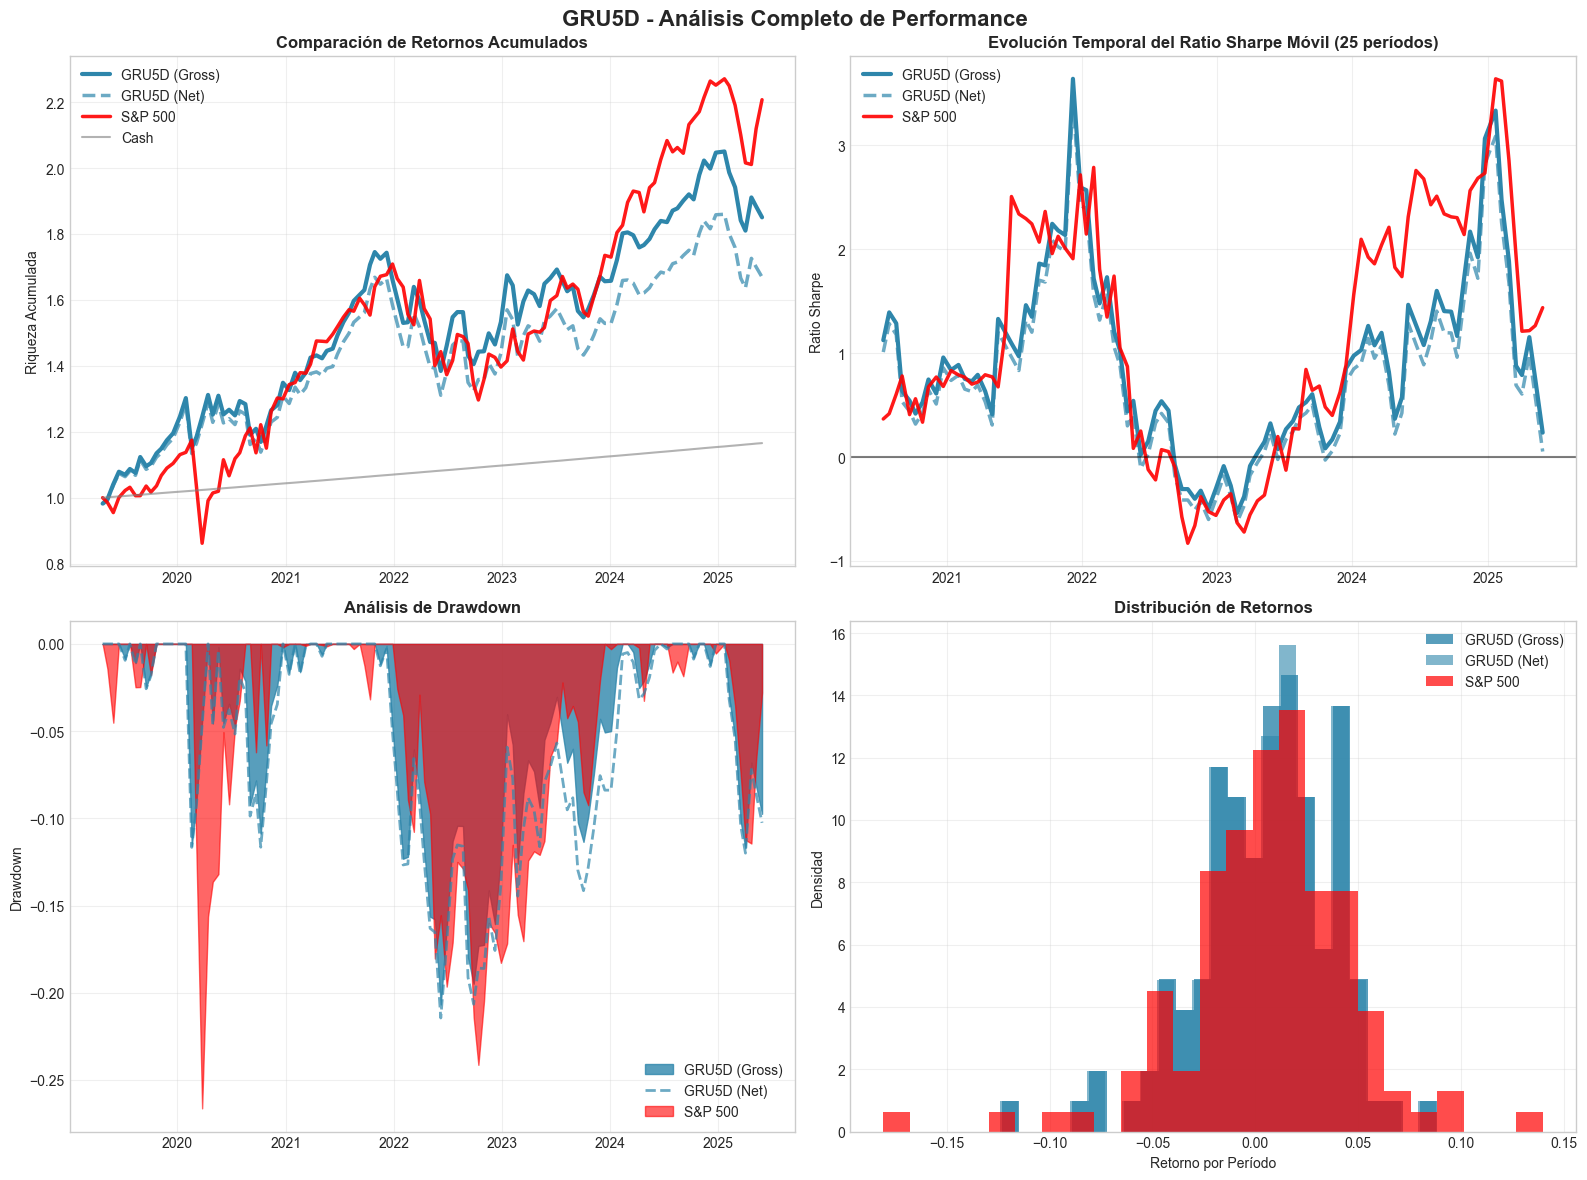

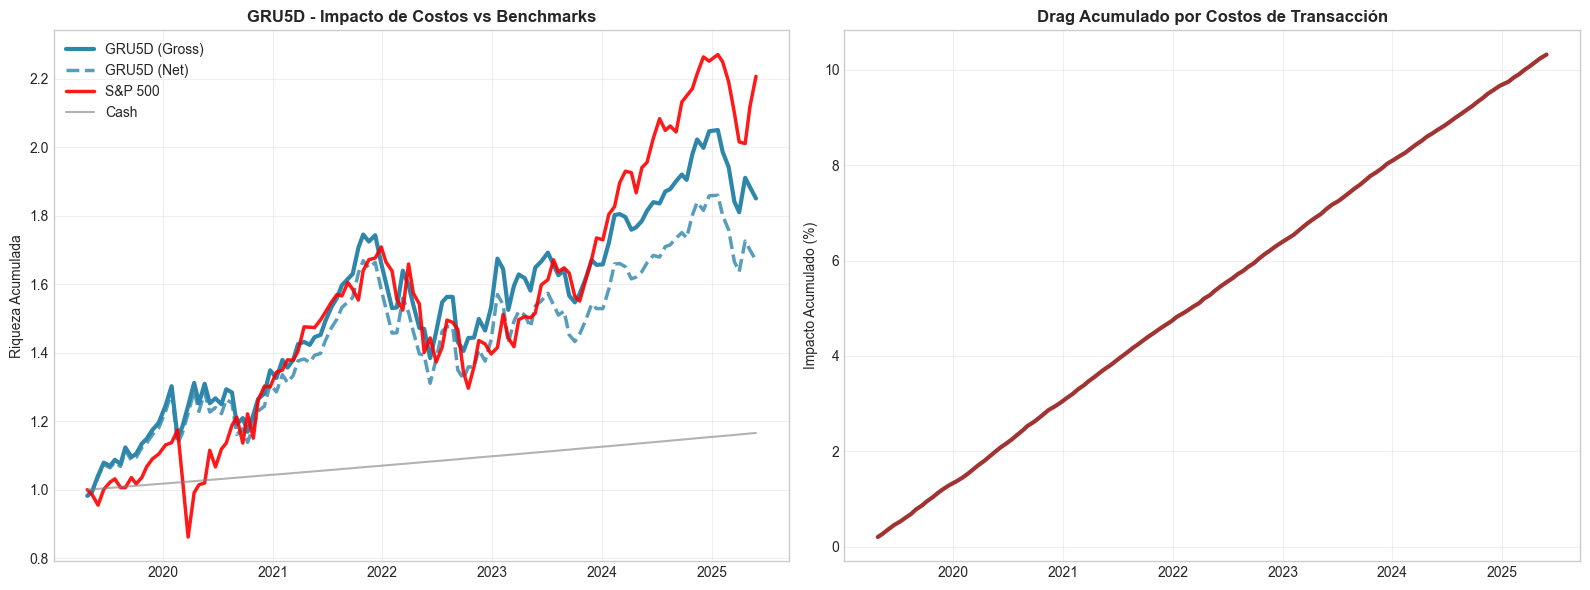


 ANÁLISIS POR RÉGIMEN DE MERCADO - GRU5D
          Régimen  Observaciones Retorno Anual Volatilidad Anual Sharpe Tasa Acierto
 Baja Volatilidad             33       -39.36%            40.79% -0.965       54.55%
Volatilidad Media             55       960.69%            52.99% 18.130       69.09%
 Alta Volatilidad             33        -6.01%            64.44% -0.093       51.52%

  ANÁLISIS DE EFICIENCIA DE TRADING - GRU5D
 Estadísticas de Turnover:
   • Turnover Promedio: 42.65%
   • Turnover Mediano: 42.25%
   • Turnover Máximo: 100.00%
   • Frecuencia Rebalanceo: 100.0% de los días

 Análisis de Costos:
   • Retorno Anual Bruto: 128.18%
   • Retorno Anual Neto: 106.68%
   • Drag por Costos: 21.49%
   • Eficiencia de Costos: 83.23%

==============================📋 RESUMEN EJECUTIVO===============================
Rendimiento Bruto Total: +85.05%
Rendimiento Neto Total:  +66.91%
Rendimiento S&P 500:     +120.73%
Alpha Bruto vs SPY:      -35.68%
Alpha Neto vs SPY:       -53.82%


In [135]:
# ════════════════════════════════════════════════════════════════════════════════
#  EJECUCIÓN DEL ANÁLISIS COMPLETO
# ════════════════════════════════════════════════════════════════════════════════

import os
import pathlib

# Asegurar que estamos en el directorio correcto del proyecto
project_root = pathlib.Path(__file__).parent.parent if '__file__' in locals() else pathlib.Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
    
os.chdir(project_root)
print(f" Directorio de trabajo: {os.getcwd()}")

# ════════════════════════════════════════════════════════════════════════════════
#  SELECCIONAR MODELO AQUÍ - CAMBIA SOLO ESTA LÍNEA
# ════════════════════════════════════════════════════════════════════════════════
SELECTED_MODEL = "gru5d"  # ← CAMBIA AQUÍ: lstm5d, xgb_enhanced, cnn5d, gru5d, etc.

print(f"\n{'🔬 INICIANDO ANÁLISIS PROFESIONAL':=^80}")
print(f"Modelo: {SELECTED_MODEL.upper()}")
print(f"Archivo de resultados: results/backtest_{SELECTED_MODEL}.pkl")

# Verificar que el archivo existe
backtest_file = pathlib.Path(f"results/backtest_{SELECTED_MODEL}.pkl")
print(f"📊 Archivo existe: {backtest_file.exists()}")
print(f"📊 Ruta completa: {backtest_file.absolute()}")
print("="*80)

try:
    # 1. Cargar resultados del backtest
    import joblib
    print(f" Cargando {backtest_file}...")
    bt_df = joblib.load(backtest_file)
    print(f" Datos cargados exitosamente: {len(bt_df)} registros")
    
    # 2. Cargar y ALINEAR benchmarks
    print("\n Cargando y alineando benchmarks...")
    bench_daily = load_benchmark_data(bt_df.index[0], bt_df.index[-1])
    
    #  CORRECCIÓN CLAVE: Acumular retornos diarios del benchmark en cada período de rebalanceo
    spy_periods = []
    bil_periods = []
    for i, rebal_date in enumerate(bt_df.index):
        start_period = bench_daily.index.min() if i == 0 else bt_df.index[i-1]
        mask = (bench_daily.index > start_period) & (bench_daily.index <= rebal_date)
        
        spy_periods.append(bench_daily.loc[mask, 'SPY'].sum())
        bil_periods.append(bench_daily.loc[mask, 'BIL'].sum())

    bench_aligned = pd.DataFrame({'SPY': spy_periods, 'BIL': bil_periods}, index=bt_df.index)
    bt_aligned = bt_df.copy()
    
    print(f" Benchmarks alineados a {len(bt_aligned)} períodos.")

    # 3. Calcular métricas (pasando la frecuencia correcta)
    print(f"\n{' MÉTRICAS DE PERFORMANCE':=^80}")
    
    freq = cfg.REBAL_FREQ # <-- Usar la frecuencia de tu config
    
    metrics = [
        calculate_comprehensive_metrics(bt_aligned['ret_bruto'], f"{SELECTED_MODEL.upper()} (Gross)", rebal_freq=freq),
        calculate_comprehensive_metrics(bt_aligned['ret_neto'], f"{SELECTED_MODEL.upper()} (Net)", rebal_freq=freq),
        calculate_comprehensive_metrics(bench_aligned['SPY'], "S&P 500 (SPY)", rebal_freq=freq),
        calculate_comprehensive_metrics(bench_aligned['BIL'], "Cash (BIL)", rebal_freq=freq)
    ]
    
    metrics_df = pd.DataFrame(metrics)
    print(metrics_df.to_string(index=False))
    
    # 4. Generar TODOS los gráficos y análisis
    print(f"\n{' GENERANDO GRÁFICOS DE ANÁLISIS':=^80}")
    
    
    # Calcular curvas acumuladas
    gross_cum = np.exp(bt_aligned['ret_bruto'].cumsum())
    net_cum = np.exp(bt_aligned['ret_neto'].cumsum())
    spy_cum = np.exp(bench_aligned['SPY'].cumsum())
    bil_cum = np.exp(bench_aligned['BIL'].cumsum())
    
    # Crear figura 2x2 mejorada
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{SELECTED_MODEL.upper()} - Análisis Completo de Performance', fontsize=16, fontweight='bold')
    
    # 1. CURVAS DE EQUITY MEJORADAS
    ax1 = axes[0, 0]
    ax1.plot(gross_cum.index, gross_cum.values, linewidth=3, label=f'{SELECTED_MODEL.upper()} (Gross)', color='#2E86AB')
    ax1.plot(net_cum.index, net_cum.values, linewidth=2.5, label=f'{SELECTED_MODEL.upper()} (Net)', 
             color='#2E86AB', linestyle='--', alpha=0.7)
    ax1.plot(spy_cum.index, spy_cum.values, linewidth=2.5, label='S&P 500', color='red', alpha=0.9)
    ax1.plot(bil_cum.index, bil_cum.values, linewidth=1.5, label='Cash', color='gray', alpha=0.6)
    ax1.set_title('Comparación de Retornos Acumulados', fontweight='bold')
    ax1.set_ylabel('Riqueza Acumulada')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. SHARPE RATIO MÓVIL MEJORADO
    ax2 = axes[0, 1]
    window = max(12, min(25, len(bt_aligned) // 3))
    
    if len(bt_aligned) > window:
        periods_per_year = 252 / cfg.REBAL_FREQ
        
        # Calcular Sharpe móvil
        gross_rolling_mean = bt_aligned['ret_bruto'].rolling(window).mean()
        gross_rolling_std = bt_aligned['ret_bruto'].rolling(window).std()
        gross_rolling_sharpe = (gross_rolling_mean / gross_rolling_std * np.sqrt(periods_per_year)).dropna()
        
        net_rolling_mean = bt_aligned['ret_neto'].rolling(window).mean()
        net_rolling_std = bt_aligned['ret_neto'].rolling(window).std()
        net_rolling_sharpe = (net_rolling_mean / net_rolling_std * np.sqrt(periods_per_year)).dropna()
        
        spy_rolling_mean = bench_aligned['SPY'].rolling(window).mean()
        spy_rolling_std = bench_aligned['SPY'].rolling(window).std()
        spy_rolling_sharpe = (spy_rolling_mean / spy_rolling_std * np.sqrt(periods_per_year)).dropna()
        
        if len(gross_rolling_sharpe) > 0:
            ax2.plot(gross_rolling_sharpe.index, gross_rolling_sharpe.values, 
                    linewidth=3, label=f'{SELECTED_MODEL.upper()} (Gross)', color='#2E86AB')
            ax2.plot(net_rolling_sharpe.index, net_rolling_sharpe.values, 
                    linewidth=2.5, label=f'{SELECTED_MODEL.upper()} (Net)', 
                    color='#2E86AB', linestyle='--', alpha=0.7)
            ax2.plot(spy_rolling_sharpe.index, spy_rolling_sharpe.values, 
                    linewidth=2.5, label='S&P 500', color='red', alpha=0.9)
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            ax2.set_title(f'Evolución Temporal del Ratio Sharpe Móvil ({window} períodos)', fontweight='bold')
            ax2.set_ylabel('Ratio Sharpe')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
    
    # 3. ANÁLISIS DE DRAWDOWN MEJORADO
    ax3 = axes[1, 0]
    gross_drawdown = (gross_cum - gross_cum.expanding().max()) / gross_cum.expanding().max()
    net_drawdown = (net_cum - net_cum.expanding().max()) / net_cum.expanding().max()
    spy_drawdown = (spy_cum - spy_cum.expanding().max()) / spy_cum.expanding().max()
    
    ax3.fill_between(gross_drawdown.index, gross_drawdown.values, 0, 
                    alpha=0.8, color='#2E86AB', label=f'{SELECTED_MODEL.upper()} (Gross)')
    ax3.plot(net_drawdown.index, net_drawdown.values, 
             linewidth=2, color='#2E86AB', linestyle='--', alpha=0.7, label=f'{SELECTED_MODEL.upper()} (Net)')
    ax3.fill_between(spy_drawdown.index, spy_drawdown.values, 0, 
                    alpha=0.6, color='red', label='S&P 500')
    ax3.set_title('Análisis de Drawdown', fontweight='bold')
    ax3.set_ylabel('Drawdown')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. DISTRIBUCIÓN DE RETORNOS MEJORADA
    ax4 = axes[1, 1]
    ax4.hist(bt_aligned['ret_bruto'].values, bins=25, alpha=0.8, color='#2E86AB', 
            label=f'{SELECTED_MODEL.upper()} (Gross)', density=True)
    ax4.hist(bt_aligned['ret_neto'].values, bins=25, alpha=0.6, color='#2E86AB', 
            label=f'{SELECTED_MODEL.upper()} (Net)', density=True, linestyle='--')
    ax4.hist(bench_aligned['SPY'].values, bins=25, alpha=0.7, color='red', 
            label='S&P 500', density=True)
    ax4.set_title('Distribución de Retornos', fontweight='bold')
    ax4.set_xlabel('Retorno por Período')
    ax4.set_ylabel('Densidad')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Impacto de costos con SPY y BIL de referencia
    ax1.plot(gross_cum.index, gross_cum.values, linewidth=3, label=f'{SELECTED_MODEL.upper()} (Gross)', color='#2E86AB')
    ax1.plot(net_cum.index, net_cum.values, linewidth=2.5, label=f'{SELECTED_MODEL.upper()} (Net)', 
             color='#2E86AB', linestyle='--', alpha=0.8)
    ax1.plot(spy_cum.index, spy_cum.values, linewidth=2.5, label='S&P 500', color='red', alpha=0.9)
    ax1.plot(bil_cum.index, bil_cum.values, linewidth=1.5, label='Cash', color='gray', alpha=0.6)
    ax1.set_title(f'{SELECTED_MODEL.upper()} - Impacto de Costos vs Benchmarks', fontweight='bold')
    ax1.set_ylabel('Riqueza Acumulada')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    cost_impact = bt_aligned['ret_bruto'] - bt_aligned['ret_neto']
    ax2.plot(cost_impact.index, cost_impact.cumsum() * 100, linewidth=3, color='darkred', alpha=0.8)
    ax2.set_title('Drag Acumulado por Costos de Transacción', fontweight='bold')
    ax2.set_ylabel('Impacto Acumulado (%)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Análisis de régimen y eficiencia (con modelo seleccionado)
    analyze_regime_performance(bt_aligned['ret_neto'], SELECTED_MODEL)
    generate_trading_efficiency_analysis(bt_aligned, SELECTED_MODEL)
    
    # 6. Resumen ejecutivo
    print(f"\n{'📋 RESUMEN EJECUTIVO':=^80}")
    total_gross = np.exp(bt_aligned['ret_bruto'].sum()) - 1
    total_net = np.exp(bt_aligned['ret_neto'].sum()) - 1
    total_spy = np.exp(bench_aligned['SPY'].sum()) - 1
    outperformance_gross = total_gross - total_spy
    outperformance_net = total_net - total_spy
    
    print(f"Rendimiento Bruto Total: {total_gross:+.2%}")
    print(f"Rendimiento Neto Total:  {total_net:+.2%}")
    print(f"Rendimiento S&P 500:     {total_spy:+.2%}")
    print(f"Alpha Bruto vs SPY:      {outperformance_gross:+.2%}")
    print(f"Alpha Neto vs SPY:       {outperformance_net:+.2%}")

except FileNotFoundError:
    print(f" ERROR: No se encontró el archivo {backtest_file}")
    print("   Asegúrate de haber ejecutado completamente el backtest primero.")
except Exception as e:
    import traceback
    print(f" ERROR INESPERADO: {str(e)}")
    traceback.print_exc()